# <font color='#1a5276'> <b> <center> Simple Regression </center> </b> </font>

## <font color='blue'>  Table of Contents </font>

1. [Introduction](#1)
2. [Setup](#2)
3. [Helper Functions](#3) <br>
4. [Data](#4) <br>
5. [Model and cost function](#5)
6. [Training](#6)
7. [References](#references)

<a name="1"></a>
## <font color='blue'> <b> 1. Introduction </b> </font>

In this notebook, we'll solve a simple linear regression problem using PyTorch. We'll generate synthetic data, define a model, and train it to predict the target variable. By the end, you'll have a trained model that can make predictions based on new input data.

<a name="2"></a>
## <font color='blue'> <b> 2. Setup</b> </font>

In [4]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import torch

<a name="3"></a>
## <font color='blue'> <b> 3. Helper Functions </b> </font>

In [6]:
# The class for plotting the error surface diagram
class PlotErrorSurfaces(object):
    
    # Constructor: Initializes the object with the given ranges, data, and number of samples
    def __init__(self, w_range, b_range, X, Y, n_samples = 30, go = True, figsize=(7.5, 5)):
        # Create linearly spaced values for weights (w) and bias (b) within the given ranges
        W = np.linspace(-w_range, w_range, n_samples)
        B = np.linspace(-b_range, b_range, n_samples)
        
        # Create a mesh grid for the weight and bias values
        w, b = np.meshgrid(W, B)
        
        # Initialize a zero matrix for storing the cost (loss) values
        Z = np.zeros((30,30))
        count1 = 0
        
        # Convert the input tensors (X and Y) to numpy arrays
        self.y = Y.numpy()
        self.x = X.numpy()
        
        # Calculate the Mean Squared Error (MSE) for each pair of weight and bias
        for w1, b1 in zip(w, b):
            count2 = 0
            for w2, b2 in zip(w1, b1):
                Z[count1, count2] = np.mean((self.y - w2 * self.x + b2) ** 2)
                count2 += 1
            count1 += 1
        
        # Store the results
        self.Z = Z
        self.w = w
        self.b = b
        
        # Initialize empty lists to store the parameters and loss values
        self.W = []
        self.B = []
        self.LOSS = []
        
        # Initialize iteration counter
        self.n = 0
        
        # If go is True, plot the initial surface and contour
        if go == True:
            plt.figure()
            plt.figure(figsize = figsize)
            # Plot 3D surface for the cost/loss surface
            plt.axes(projection='3d').plot_surface(self.w, self.b, self.Z, rstride = 1, cstride = 1, 
                                                   cmap = 'viridis', edgecolor = 'none')
            plt.title('Cost/Total Loss Surface', fontweight='bold', color='purple')
            plt.xlabel('w', fontweight='bold')
            plt.ylabel('b', fontweight='bold')
            plt.show()
            
            # Plot contour for the cost/loss surface
            plt.figure()
            plt.figure(figsize = figsize)
            plt.title('Cost/Total Loss Surface Contour', fontweight='bold', color='blue')
            plt.xlabel('w', fontweight='bold')
            plt.ylabel('b', fontweight='bold')
            plt.contour(self.w, self.b, self.Z)
            plt.show()
    
    # Setter: Updates the parameters and loss values during training
    def set_para_loss(self, W, B, loss):
        self.n = self.n + 1  # Increment the iteration counter
        self.W.append(W)  # Append the current weight
        self.B.append(B)  # Append the current bias
        self.LOSS.append(loss)  # Append the current loss
    
    # Final plot: Displays the final 3D wireframe and contour plots
    def final_plot(self): 
        # Plot the wireframe for the cost/loss surface
        ax = plt.axes(projection = '3d')
        ax.plot_wireframe(self.w, self.b, self.Z)
        # Plot the recorded parameter points and their corresponding losses
        ax.scatter(self.W, self.B, self.LOSS, c = 'r', marker = 'x', s = 200, alpha = 1)
        
        # Plot the contour plot for the cost/loss surface
        plt.figure()
        plt.contour(self.w, self.b, self.Z)
        plt.scatter(self.W, self.B, c = 'r', marker = 'x')
        plt.xlabel('w')
        plt.ylabel('b')
        plt.show()
    
    # Plot data space and loss surface contours during training
    def plot_ps(self):
        # Plot the training data points and the estimated line
        plt.subplot(121)
        plt.ylim
        plt.plot(self.x, self.y, 'ro', label="training points")
        plt.plot(self.x, self.W[-1] * self.x + self.B[-1], label = "estimated line")
        plt.xlabel('x')
        plt.ylabel('y')
        plt.ylim((-10, 15))  # Set y-axis limits for better visualization
        plt.title('Data Space Iteration: ' + str(self.n))

        # Plot the contour of the total loss surface along with the recorded parameter points
        plt.subplot(122)
        plt.contour(self.w, self.b, self.Z)
        plt.scatter(self.W, self.B, c = 'r', marker = 'x')
        plt.title('Total Loss Surface Contour Iteration' + str(self.n))
        plt.xlabel('w')
        plt.ylabel('b')
        plt.show()


<a name="4"></a>
## <font color='blue'> <b> 4. Data </b> </font>

For this example, we will create synthetic data.

We start by generating values in the range of -3 to 3 to create a line with a slope of 1 and a bias of -1. This is the line we need to estimate.

In [7]:
# f(x) = 1x - 1 

X = torch.arange(-3, 3, 0.1).view(-1, 1)
f = 1 * X - 1

In [8]:
# Add noise

Y = f + 0.1 * torch.randn(X.size())

Plot the line and the noisy points:

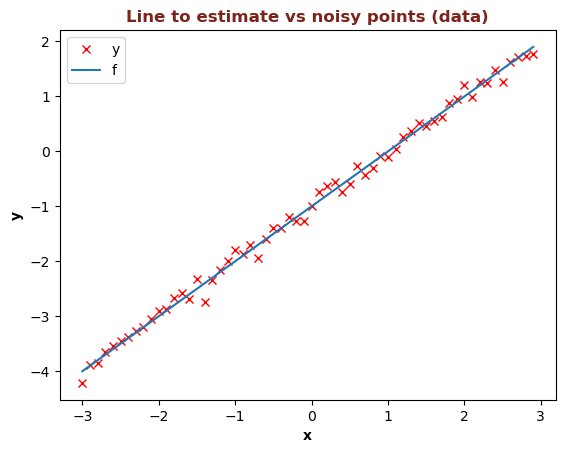

In [9]:
plt.plot(X.numpy(), Y.numpy(), 'rx', label = 'y')
plt.plot(X.numpy(), f.numpy(), label = 'f')
plt.xlabel('x', fontweight='bold')
plt.ylabel('y', fontweight='bold')
plt.title('Line to estimate vs noisy points (data)', fontweight='bold', color='#7b241c')
plt.legend()

<a name="5"></a>
## <font color='blue'> <b> 5. Model and cost function </b> </font>

Forward function

In [10]:
def forward(x, w, b):
    return w*x + b


Cost function (it will be MSE)

In [11]:
def criterion(yhat, y):
    return torch.mean((yhat - y) ** 2)


We create a <code>plot_error_surfaces</code> object to visualize the data and parameter space during training.

<Figure size 640x480 with 0 Axes>

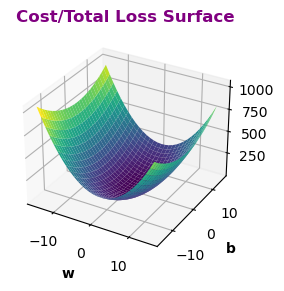

<Figure size 640x480 with 0 Axes>

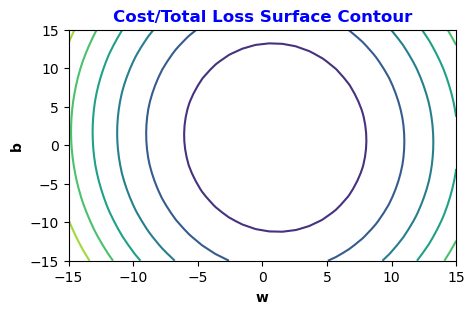

In [12]:
# Create plot_error_surfaces for viewing the data
get_surface = PlotErrorSurfaces(15, 15, X, Y, 30, figsize=(5, 3))

<a name="6"></a>
## <font color='blue'> <b> 6. Training </b> </font>

We will create the model parameters w and b and set requires_grad=True since we need to learn them through differentiation.

In [13]:
# Define the parameters w, b for y = wx + b
# -15 and -10 are initial values for w and b, respectively
w = torch.tensor(-15.0, requires_grad = True)
b = torch.tensor(-10.0, requires_grad = True)

Function to train the model:

In [14]:
def train_model(iter, X, y):
    
    
    # Define learning rate and create an empty list for containing the loss for each iteration.
    lr = 0.1
    loss_results = []
    
    # loop
    for epoch in range(iter):
        
        # make a prediction
        y_hat = forward(X, w, b)
        
        # calculate the loss
        loss = criterion(y_hat, y)
        
        # plotting
        get_surface.set_para_loss(w.data.tolist(), b.data.tolist(), loss.tolist())
        if epoch % 3 == 0:
            get_surface.plot_ps()
            
        # store the loss in the list LOSS
        loss_results.append(loss.item())
        # loss_results.append(loss.item())  # Append the scalar value, in general better approach
        
        # backward pass: compute gradient of the loss with respect to the learnable parameters
        loss.backward()
        
        # update parameters slope and bias
        w.data = w.data - lr * w.grad.data
        b.data = b.data - lr * b.grad.data
        
        # zero the gradients before running the backward pass
        w.grad.data.zero_()
        b.grad.data.zero_()
    
    return loss_results


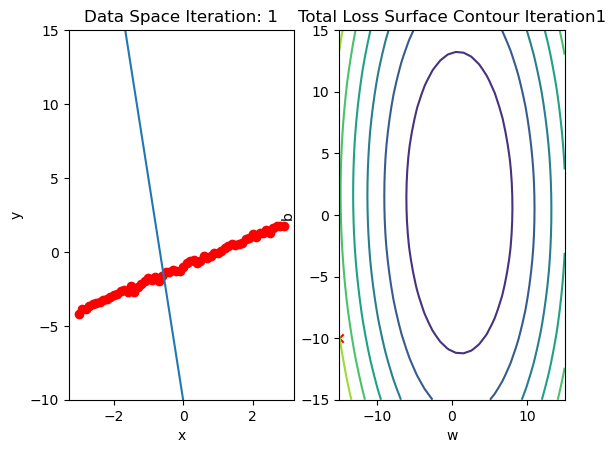

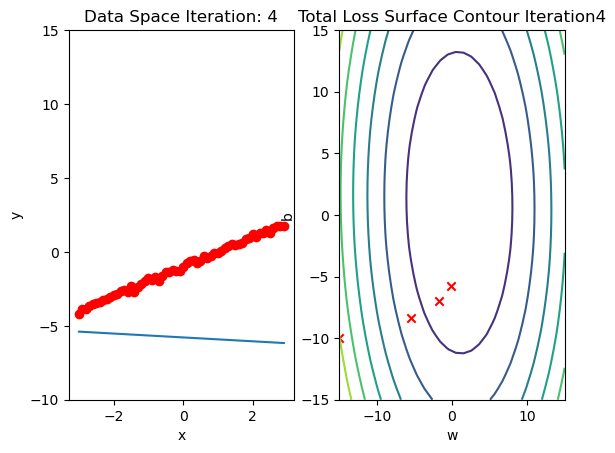

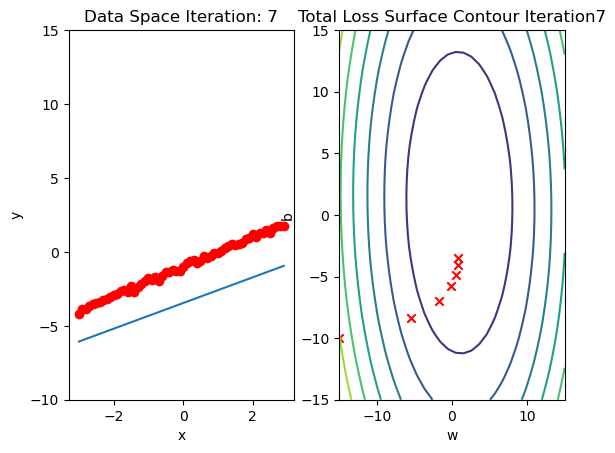

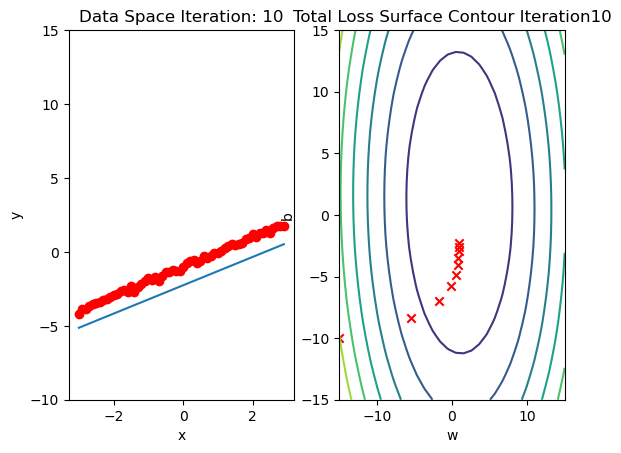

In [15]:
loss_results = train_model(10, X, Y)

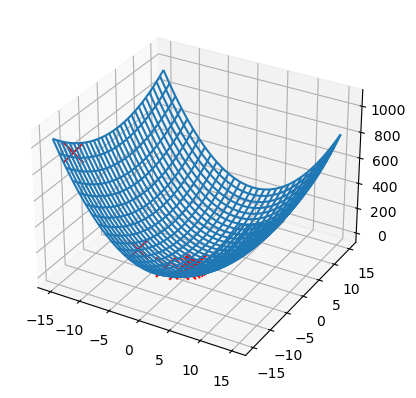

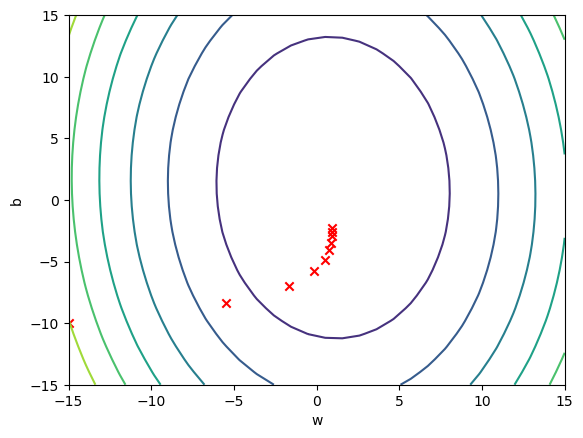

Text(33.097222222222214, 0.5, 'Cost')

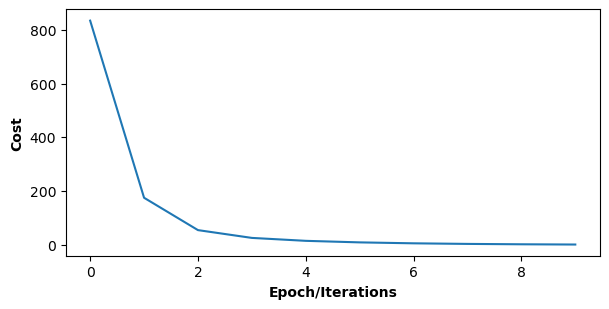

In [16]:
# Plot out the Loss Result

# surface
get_surface.final_plot()

# loss
plt.figure(figsize=(6, 3)) 
plt.plot(loss_results)
plt.tight_layout()
plt.xlabel("Epoch/Iterations", fontweight='bold')
plt.ylabel("Cost", fontweight='bold')

<a name="references"></a>
## <font color='blue'> <b> References </b> </font>

[IBM AI Engineering Professional Certificate](https://www.coursera.org/professional-certificates/ai-engineer)